In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [3]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [4]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.5413 - acc: 0.8620 - val_loss: 0.3322 - val_acc: 0.9125
Epoch 2/5
60000/60000 [==============================] - 3s 51us/step - loss: 0.3230 - acc: 0.9107 - val_loss: 0.2930 - val_acc: 0.9190
Epoch 3/5
60000/60000 [==============================] - 3s 56us/step - loss: 0.2955 - acc: 0.9178 - val_loss: 0.2786 - val_acc: 0.9220
Epoch 4/5
60000/60000 [==============================] - 3s 49us/step - loss: 0.2819 - acc: 0.9215 - val_loss: 0.2713 - val_acc: 0.9243
Epoch 5/5
60000/60000 [==============================] - 3s 50us/step - loss: 0.2737 - acc: 0.9237 - val_loss: 0.2722 - val_acc: 0.9227


In [5]:
@functools.lru_cache()
def get_grad(i):
    print(f'generating grad model of digit {i}')
    X = M(X_input)
    X = %time keras.layers.Lambda( \
        lambda x,i: K.gradients(x[1][:,i], x[0])[0], \
        output_shape=(28,28,1), \
        arguments={'i':i})([X_input, X])
    G = keras.Model(X_input, X)
    G.compile('adam', 'mse')
    return G
@functools.lru_cache()
def get_curv(i):
    print(f'generating curv model of digit {i}')
    X = get_grad(i)(X_input)
    def compute_hessian(x):
        return K.stop_gradient(K.reshape(K.stack([
            K.gradients(x[1][:,iy,ix,:], x[0])[0]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1,28,28,1)))
    def compute_curv(x):
        h = compute_hessian(x)
        return K.stop_gradient(K.reshape(K.stack([
            h[:,iy,ix,:,iy,ix,:]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1)))
    X = %time keras.layers.Lambda( \
        compute_curv, output_shape=(28,28,1))([X_input, X])
    C = keras.Model(X_input, X)
    C.compile('adam', 'mse')
    return C

generating grad model of digit 0
CPU times: user 17.5 ms, sys: 35 µs, total: 17.5 ms
Wall time: 17.1 ms
generating grad model of digit 1
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 12.2 ms
generating grad model of digit 2
CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.3 ms
generating grad model of digit 3
CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.3 ms
generating grad model of digit 4
CPU times: user 12.3 ms, sys: 214 µs, total: 12.5 ms
Wall time: 12.2 ms
generating grad model of digit 5
CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.4 ms
generating grad model of digit 6
CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 12.8 ms
generating grad model of digit 7
CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 12.4 ms
generating grad model of digit 8
CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 16.1 ms
generating grad model of digit 9
CPU times: user 13.8 ms, sys: 13 µs, 

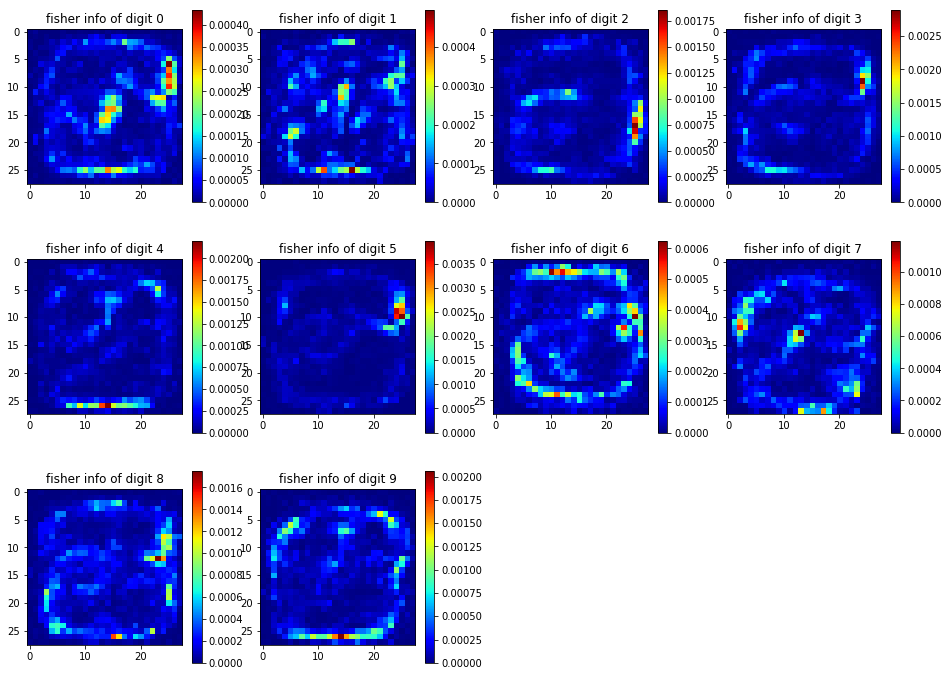

In [6]:
plt.figure(figsize=(16,12))
for i in range(10):
    vgrad = get_grad(i).predict(xtest)
    vgrad = np.var(vgrad, axis=0, ddof=1, keepdims=True)
    plt.subplot(3,4,i+1)
    plt.title(f'fisher info of digit {i}')
    plt.imshow(vgrad[0,:,:,0], cmap='jet', vmin=0)
    plt.colorbar()
plt.show()

In [7]:
def test_plot(test_label, improve_as):
    G,C = get_grad(improve_as), get_curv(improve_as)
    test_idx = np.random.choice(np.where(ytest == test_label)[0])
    test = xtest[test_idx:test_idx+1]
    pred = M.predict(test)
    grad = G.predict(test)
    curv = C.predict(test)
    digit = np.argmax(pred[0])
    plt.figure(figsize=(16,4))
    plt.suptitle(f'labeled as {test_label}, predicted as {digit} ({pred[0,digit]:.4f}), improve to be {improve_as}', fontsize=16)
    plt.subplot(1,4,1)
    plt.title('input')
    plt.imshow(test[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.title('gradients')
    plt.imshow(grad[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.title('curvatures')
    plt.imshow(curv[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.title('abs(curvatures)')
    plt.imshow(abs(curv[0,:,:,0]), cmap='jet', vmin=0)
    plt.colorbar()
    plt.show()

generating curv model of digit 8
CPU times: user 1min 25s, sys: 993 ms, total: 1min 26s
Wall time: 1min 25s


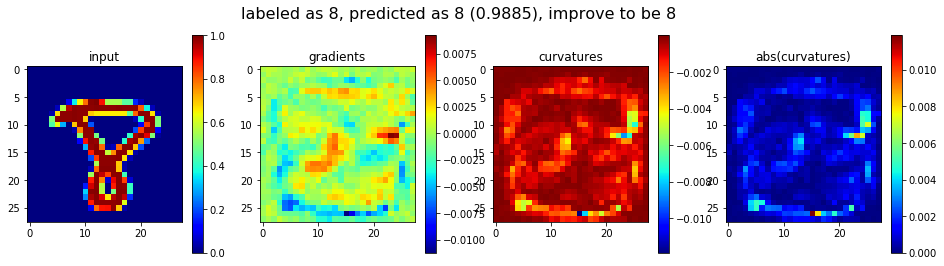

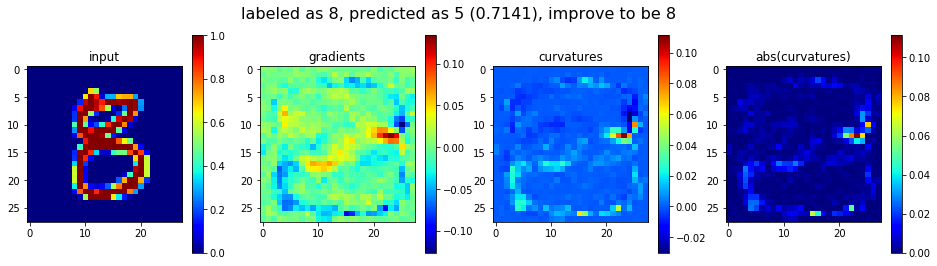

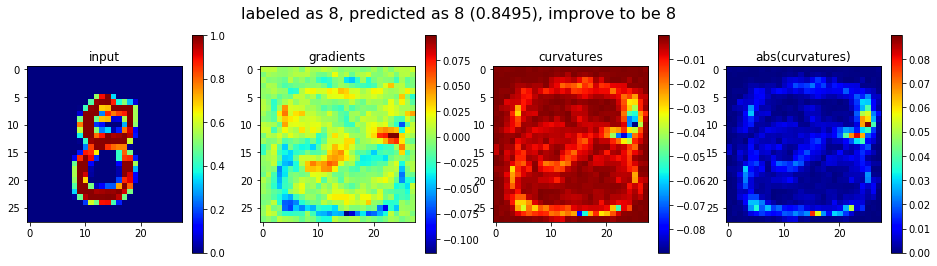

In [8]:
for _ in range(3):
    test_plot(8, 8)

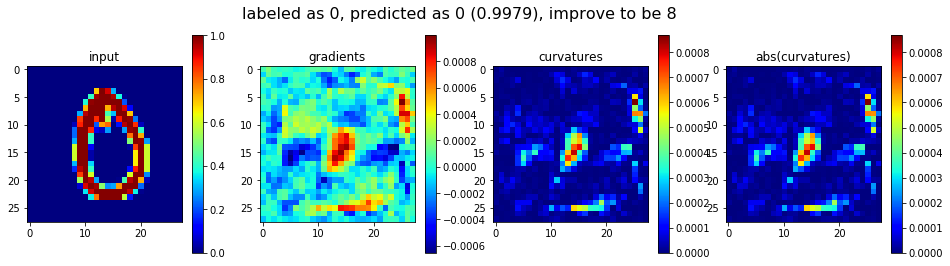

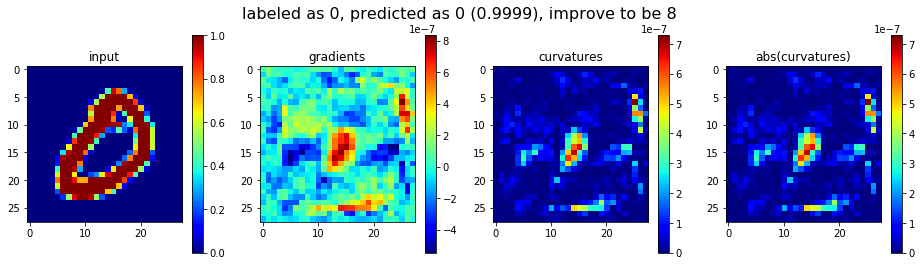

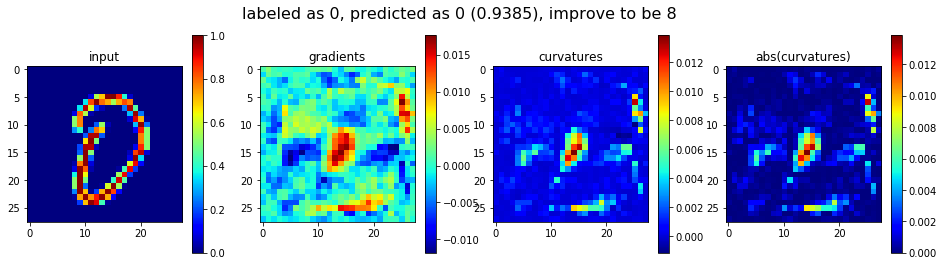

In [9]:
for _ in range(3):
    test_plot(0, 8)

generating curv model of digit 2
CPU times: user 2min 58s, sys: 1.54 s, total: 3min
Wall time: 2min 57s


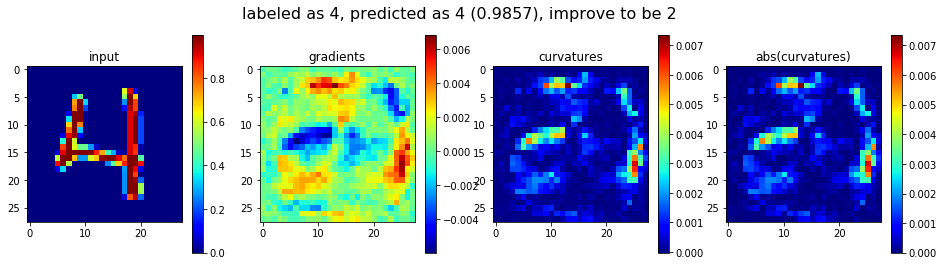

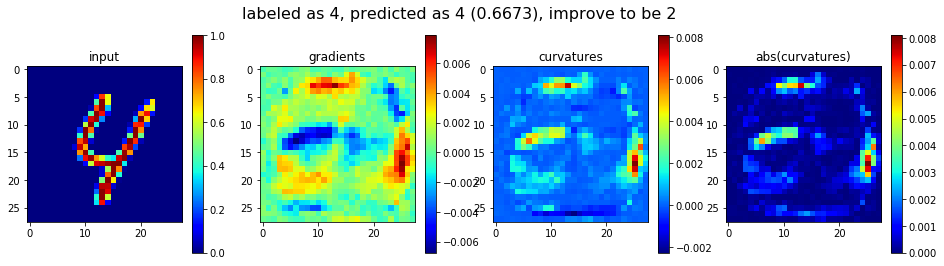

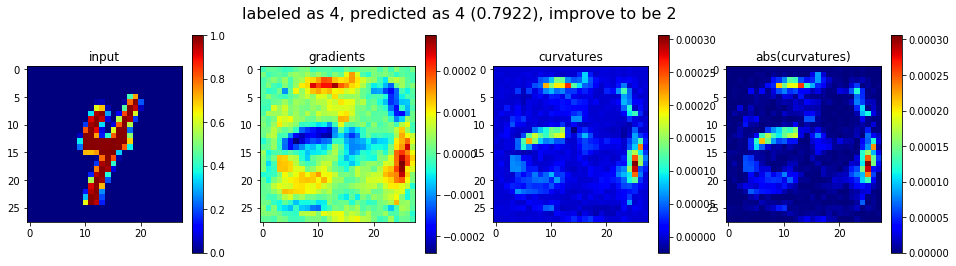

In [10]:
for _ in range(3):
    test_plot(4, 2)